In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# imports
import pystac_client
import xarray as xr
import matplotlib.pyplot as plt
import pathlib
import os
import numpy as np
import geopandas as gpd
import matplotlib as mpl
from matplotlib import colors
import rasterio

import cartopy.crs as ccrs
import cartopy
import plotly.graph_objects as go
import plotly.express as px
from rasterio.plot import show

import matplotlib.colors as mcolors
from shapely.geometry import Point
import pandas as pd

from tqdm import tqdm

import webbrowser
from pathlib import Path
import os
import time

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report



In [48]:
groundtruth=pd.read_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data_CVI_components\Caribbean Thesis_Results\Validation\Expert_Feedback_collated.csv",sep=";")
# groundtruth=groundtruth.iloc[:,:-5]
# groundtruth["lon"]=groundtruth["lon"].apply(lambda x: float(str(x).replace(',', '.')))
# groundtruth["lat"]=groundtruth["lat"].apply(lambda x: float(str(x).replace(',', '.')))
# groundtruth

for col in groundtruth.iloc[:,4:].columns:
    groundtruth[col]=groundtruth[col].apply(lambda x: float(x))

groundtruth.head(3)

,Country,Beach Name,lon,lat,built-up percentage (1- 5),Topography (1- 5),Bathymetry Slope (1- 5),Population (1- 5),Sediment Type (1- 5),Extreme Sea levels (1- 5),...,HealthCare (1- 5),Economics (1- 5),Literacy (1- 5),Recent Disaster shocks (1- 5),Nearby Sensitive Areas (1- 5),Extreme Sea level Risk (1- 5),Extreme offshore Wave heights Risk (1- 5),Shoreline Erosion Risk (1- 5),Land Subsidence Risk (1- 5),Hurricane Risk (Frequency & Strength) (1- 5)
0,Bahamas,Lowe Sound,"-78,08","25,15",4.0,5.0,4.0,3.0,4.0,5.0,...,3.0,3.0,3.0,3.0,2.0,5.0,4.0,3.0,3.0,4.0
1,Bahamas,Regatta,"-77,55","24,1",3.0,3.0,4.0,3.0,4.0,3.0,...,3.0,3.0,3.0,3.0,2.0,5.0,4.0,4.0,3.0,4.0
2,Turks and Caicos Islands -1,North Grace Bay,"-72,17","21,81",4.0,4.0,4.0,4.0,4.0,4.0,...,3.0,2.0,3.0,4.0,3.0,4.0,4.0,4.0,3.0,4.0


MACHINE LEARNING ALGORITHM

In [49]:
groundtruth.columns

Index(['Country', 'Beach Name', 'lon', 'lat', 'built-up percentage (1- 5)',
       'Topography (1- 5)', 'Bathymetry Slope (1- 5)', 'Population (1- 5)',
       'Sediment Type (1- 5)', 'Extreme Sea levels (1- 5)',
       'Extreme offshore Wave heights (1- 5)', 'Land subsidence (1- 5)',
       'Shoreline Erosion (1- 5)', 'Hurricane (Frequency & Strength) (1- 5)',
       'HealthCare (1- 5)', 'Economics (1- 5)', 'Literacy (1- 5)',
       'Recent Disaster shocks (1- 5)', 'Nearby Sensitive Areas (1- 5)',
       'Extreme Sea level Risk (1- 5)',
       'Extreme offshore Wave heights Risk (1- 5)',
       'Shoreline Erosion Risk (1- 5)', 'Land Subsidence Risk (1- 5)',
       'Hurricane Risk (Frequency & Strength) (1- 5)'],
      dtype='object')

Set up data for model training

In [50]:
joiner=pd.concat([groundtruth.iloc[:,9],groundtruth.iloc[:,4:9],groundtruth.iloc[:,14:19],groundtruth.iloc[:,19]],axis=1)
joiner.head(3)

,Extreme Sea levels (1- 5),built-up percentage (1- 5),Topography (1- 5),Bathymetry Slope (1- 5),Population (1- 5),Sediment Type (1- 5),HealthCare (1- 5),Economics (1- 5),Literacy (1- 5),Recent Disaster shocks (1- 5),Nearby Sensitive Areas (1- 5),Extreme Sea level Risk (1- 5)
0,5.0,4.0,5.0,4.0,3.0,4.0,3.0,3.0,3.0,3.0,2.0,5.0
1,3.0,3.0,3.0,4.0,3.0,4.0,3.0,3.0,3.0,3.0,2.0,5.0
2,4.0,4.0,4.0,4.0,4.0,4.0,3.0,2.0,3.0,4.0,3.0,4.0


In [110]:
import joblib
#use 600 different iterations of test train examples to develop statistics on the accuracies achieved by each model
iter=600

# Create an empty DataFrame with the necessary columns
df_mach_learn = pd.DataFrame({
    'hazard_name': pd.Series(dtype='str'),
    'mean_acc': pd.Series(dtype='float'),
    'median_acc': pd.Series(dtype='float'),
    'std_acc': pd.Series(dtype='float'),
    'max_acc': pd.Series(dtype='float')
})

best_models=[]
best_X_tests=[]
best_pred_all_ys=[]
best_y_preds=[]

median_models=[]
median_X_tests=[]
median_pred_all_ys=[]
median_y_preds=[]
for col in range(9,14):

    accuracies=[]
    pred_all_ys=[]
    y_preds=[]
    X_tests=[]
    models=[]
    for idx in range(0,iter):

        joiner=pd.concat([groundtruth.iloc[:,col],groundtruth.iloc[:,4:9],groundtruth.iloc[:,14:19],groundtruth.iloc[:,col+10]],axis=1)
        df = joiner.copy()


        # Splitting the data into features (X) and target (y)
        X = df.iloc[:, :-1] 
        y = df.iloc[:, -1]   

        # Split the data into training and testing sets with a 80-20 split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        X_tests.append(X_test)

        # Initialize and train the RandomForestClassifier
        model = RandomForestClassifier()
        model.fit(X_train, y_train)
        models.append(model)

        # Make predictions on the test set
        y_pred = model.predict(X_test)
        y_preds.append(y_pred)
        pred_all_y=model.predict(X)
        pred_all_ys.append(pred_all_y)

        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        accuracies_array = np.array(accuracies) * 100


    hazard_name=groundtruth.columns[col]
    mean_acc=(accuracies_array).mean()
    std_acc=(accuracies_array).std()
    max_acc=(accuracies_array).max()
    max_index=np.argmax(accuracies_array)
    sorted_acc=np.sort(accuracies_array)
    median_acc=sorted_acc[50]
    median_index=np.where(accuracies_array == median_acc)[0][0]




    # Create a dictionary for the new row
    new_row = {
        'hazard_name': hazard_name,
        'mean_acc': mean_acc,
        'median_acc': median_acc,
        'std_acc': std_acc,
        'max_acc': max_acc
    }

    # Convert the dictionary to a DataFrame
    new_row_df = pd.DataFrame([new_row])

    # Concatenate the new row DataFrame to the existing DataFrame
    df_mach_learn = pd.concat([df_mach_learn, new_row_df], ignore_index=True)



    best_models.append(models[max_index])
    best_X_tests.append(X_tests[max_index])
    best_pred_all_ys.append( pred_all_ys[max_index])
    best_y_preds.append(y_preds[max_index])

    median_models.append(models[median_index])
    median_X_tests.append(X_tests[median_index])
    median_pred_all_ys.append( pred_all_ys[median_index])
    median_y_preds.append(y_preds[median_index])

df_mach_learn


,hazard_name,mean_acc,median_acc,std_acc,max_acc
0,Extreme Sea levels (1- 5),51.619048,28.571429,17.323388,100.000000
1,Extreme offshore Wave heights (1- 5),44.547619,14.285714,17.148792,85.714286
2,Land subsidence (1- 5),26.000000,0.000000,15.034654,71.428571
3,Shoreline Erosion (1- 5),50.714286,28.571429,17.809460,100.000000
4,Hurricane (Frequency & Strength) (1- 5),60.904762,42.857143,16.124445,100.000000


Save the best models and plots

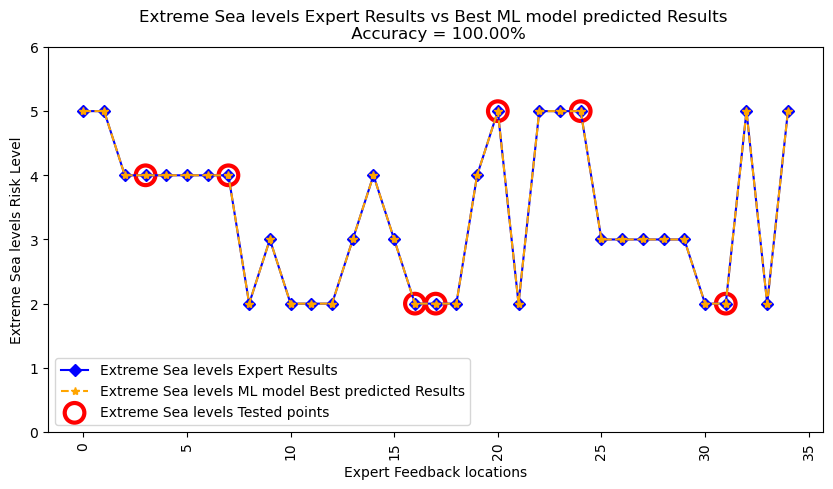

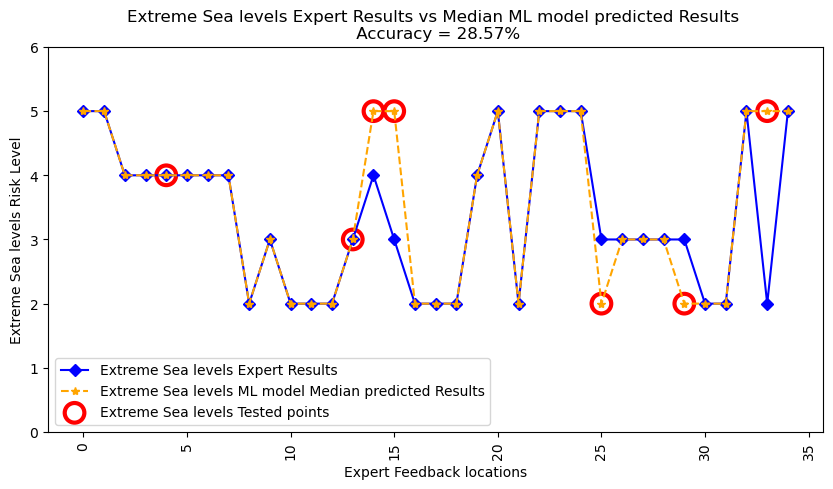

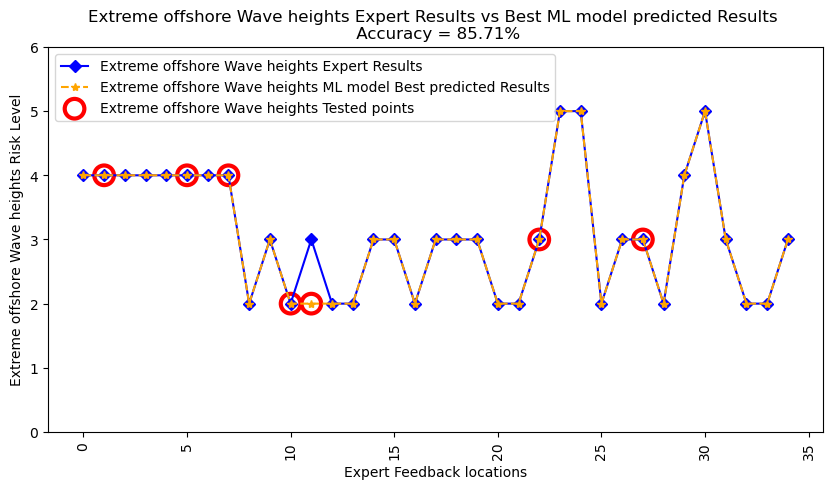

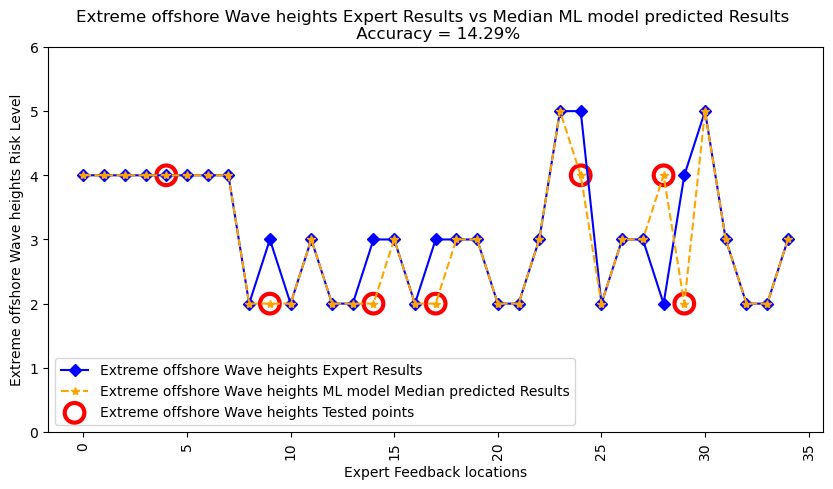

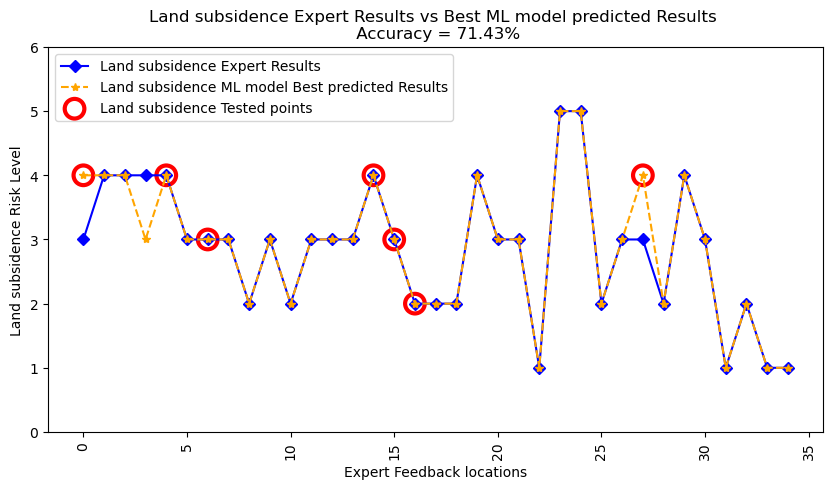

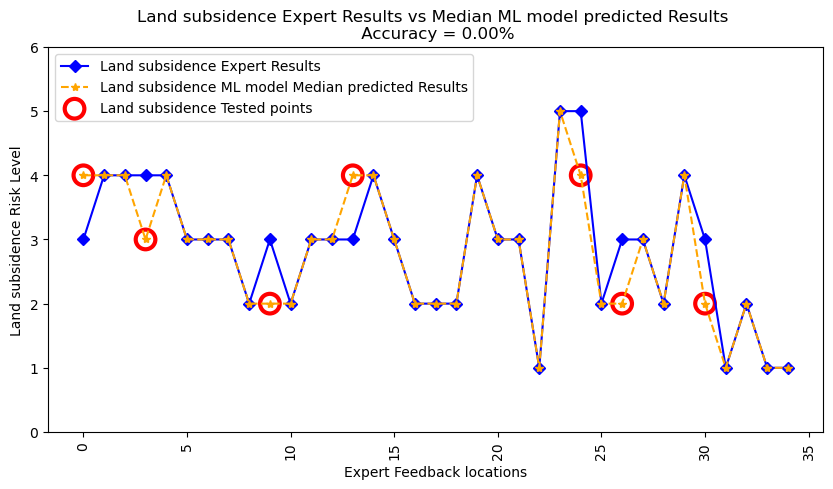

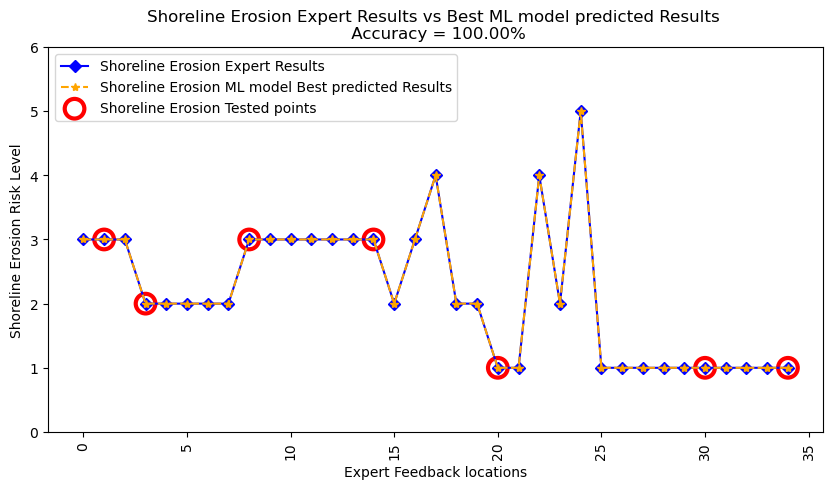

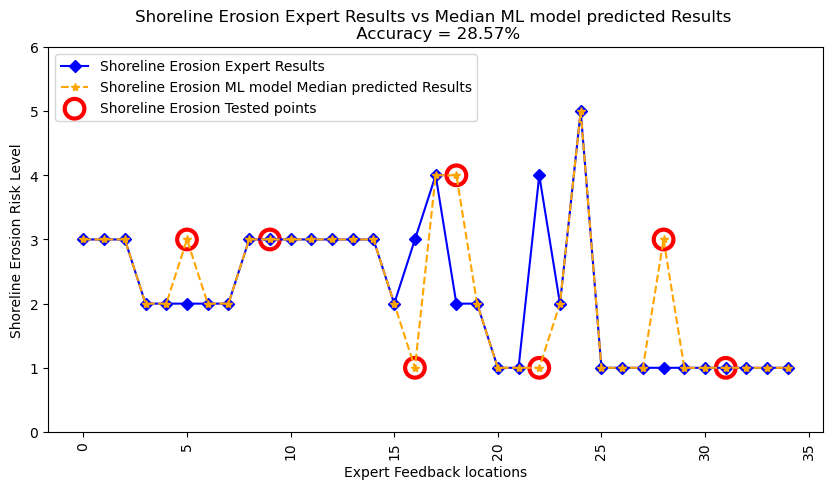

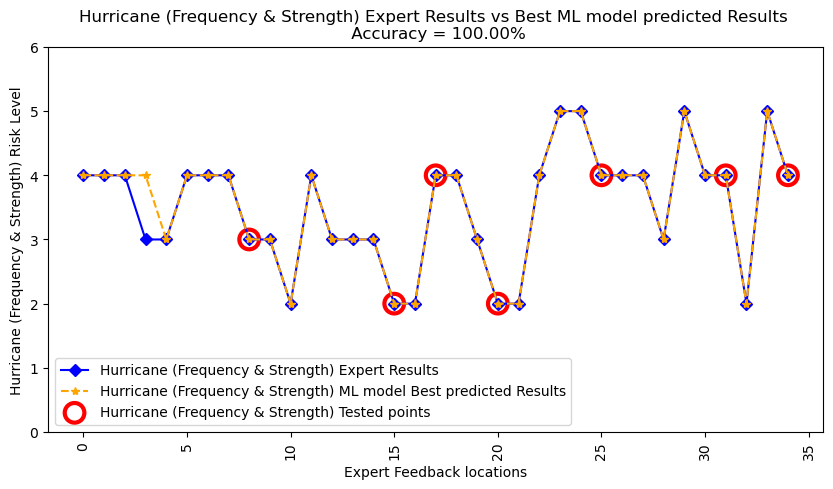

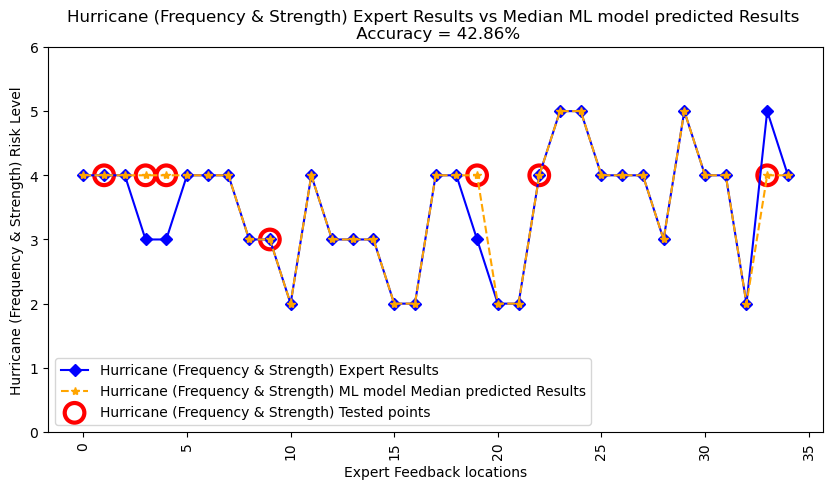

In [111]:
directory=r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data_CVI_components\Caribbean Thesis_Results\Validation\Machine Learning Models"

expert_risk=groundtruth.iloc[:,19:]
for i in range(0,len(best_models)):

    plt.figure(figsize=(10, 5))
    plt.plot(X.index ,expert_risk.iloc[:,i],"D-",color="blue")
    plt.plot(X.index ,best_pred_all_ys[i],"*--",color="orange")
    plt.scatter(best_X_tests[i].index, best_y_preds[i], color='red', facecolors='none', edgecolors='red', s=200, linewidths=3)

    plt.legend([f"{df_mach_learn.iloc[i,0].replace(' (1- 5)', '')} Expert Results",
            f"{df_mach_learn.iloc[i,0].replace(' (1- 5)', '')} ML model Best predicted Results",
            f"{df_mach_learn.iloc[i,0].replace(' (1- 5)', '')} Tested points"])

    plt.xticks(rotation=90)
    plt.ylim(0,6)
    plt.title(f"{df_mach_learn.iloc[i,0].replace(' (1- 5)', '')} Expert Results vs Best ML model predicted Results \n Accuracy = {df_mach_learn.iloc[i,-1]:.2f}%" )
    
    plt.xlabel("Expert Feedback locations")
    plt.ylabel(f"{df_mach_learn.iloc[i,0].replace(' (1- 5)', '')} Risk Level")

    
    fig_name_best=f"{df_mach_learn.iloc[i,0].replace(' (1- 5)', '')} ML model Best predicted Results"


    model_name=f"{df_mach_learn.iloc[i,0].replace(' (1- 5)', '')} ML model predicted Results.joblib"

    # Save the model to a file
    joblib.dump(best_models[i], os.path.join(directory,model_name))
    plt.savefig(os.path.join(directory,fig_name_best),dpi=300, bbox_inches='tight')



    plt.figure(figsize=(10, 5))
    plt.plot(X.index ,expert_risk.iloc[:,i],"D-",color="blue")
    plt.plot(X.index ,median_pred_all_ys[i],"*--",color="orange")
    plt.scatter(median_X_tests[i].index, median_y_preds[i], color='red', facecolors='none', edgecolors='red', s=200, linewidths=3)

    plt.legend([f"{df_mach_learn.iloc[i,0].replace(' (1- 5)', '')} Expert Results",
            f"{df_mach_learn.iloc[i,0].replace(' (1- 5)', '')} ML model Median predicted Results",
            f"{df_mach_learn.iloc[i,0].replace(' (1- 5)', '')} Tested points"])

    plt.xticks(rotation=90)
    plt.ylim(0,6)
    plt.title(f"{df_mach_learn.iloc[i,0].replace(' (1- 5)', '')} Expert Results vs Median ML model predicted Results \n Accuracy = {df_mach_learn.iloc[i,2]:.2f}%" )
    
    plt.xlabel("Expert Feedback locations")
    plt.ylabel(f"{df_mach_learn.iloc[i,0].replace(' (1- 5)', '')} Risk Level")

    
    fig_name_median=f"{df_mach_learn.iloc[i,0].replace(' (1- 5)', '')} ML model Median predicted Results"
    plt.savefig(os.path.join(directory,fig_name_median),dpi=300, bbox_inches='tight')

    plt.show()


### Convergence Check

In [98]:
import joblib
import tqdm

df_mach_learn_convergence_check=[]

for iter in tqdm.tqdm(range(1, 600), desc="Iteration number"):

    # Create an empty DataFrame with the necessary columns
    df_mach_learn = pd.DataFrame({
        'hazard_name': pd.Series(dtype='str'),
        'mean_acc': pd.Series(dtype='float'),
        'median_acc': pd.Series(dtype='float'),
        'std_acc': pd.Series(dtype='float'),
        'max_acc': pd.Series(dtype='float')
    })

    best_models=[]
    best_X_tests=[]
    best_pred_all_ys=[]
    best_y_preds=[]

    median_models=[]
    median_X_tests=[]
    median_pred_all_ys=[]
    median_y_preds=[]
    for col in range(9,14):

        accuracies=[]
        pred_all_ys=[]
        y_preds=[]
        X_tests=[]
        models=[]
        for idx in range(0,iter):

            joiner=pd.concat([groundtruth.iloc[:,col],groundtruth.iloc[:,4:9],groundtruth.iloc[:,14:19],groundtruth.iloc[:,col+10]],axis=1)
            df = joiner.copy()


            # Splitting the data into features (X) and target (y)
            X = df.iloc[:, :-1] 
            y = df.iloc[:, -1]   

            # Split the data into training and testing sets with a 80-20 split
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
            X_tests.append(X_test)

            # Initialize and train the RandomForestClassifier
            model = RandomForestClassifier()
            model.fit(X_train, y_train)
            models.append(model)

            # Make predictions on the test set
            y_pred = model.predict(X_test)
            y_preds.append(y_pred)
            pred_all_y=model.predict(X)
            pred_all_ys.append(pred_all_y)

            # Evaluate the model
            accuracy = accuracy_score(y_test, y_pred)
            accuracies.append(accuracy)
            accuracies_array = np.array(accuracies) * 100


        hazard_name=groundtruth.columns[col]
        mean_acc=(accuracies_array).mean()
        std_acc=(accuracies_array).std()
        max_acc=(accuracies_array).max()
        max_index=np.argmax(accuracies_array)
        sorted_acc=np.sort(accuracies_array)
        median_acc=sorted_acc[int(np.floor(iter/2))]
        median_index=np.where(accuracies_array == median_acc)[0][0]




        # Create a dictionary for the new row
        new_row = {
            'hazard_name': hazard_name,
            'mean_acc': mean_acc,
            'median_acc': median_acc,
            'std_acc': std_acc,
            'max_acc': max_acc
        }

        # Convert the dictionary to a DataFrame
        new_row_df = pd.DataFrame([new_row])

        # Concatenate the new row DataFrame to the existing DataFrame
        df_mach_learn = pd.concat([df_mach_learn, new_row_df], ignore_index=True)



        best_models.append(models[max_index])
        best_X_tests.append(X_tests[max_index])
        best_pred_all_ys.append( pred_all_ys[max_index])
        best_y_preds.append(y_preds[max_index])

        median_models.append(models[median_index])
        median_X_tests.append(X_tests[median_index])
        median_pred_all_ys.append( pred_all_ys[median_index])
        median_y_preds.append(y_preds[median_index])

    df_mach_learn_convergence_check.append(df_mach_learn)


Iteration number:  56%|█████▌    | 500/900 [37:11:27<29:45:09, 267.77s/it]


KeyboardInterrupt: 

Reload the model to Re-use

In [103]:
df_mach_learn_convergence_check[-1]

,hazard_name,mean_acc,median_acc,std_acc,max_acc
0,Extreme Sea levels (1- 5),51.299785,57.142857,17.731289,100.000000
1,Extreme offshore Wave heights (1- 5),43.453375,42.857143,16.611904,85.714286
2,Land subsidence (1- 5),24.850942,28.571429,14.759290,71.428571
3,Shoreline Erosion (1- 5),50.321965,57.142857,17.012039,100.000000
4,Hurricane (Frequency & Strength) (1- 5),61.435726,57.142857,17.294719,100.000000


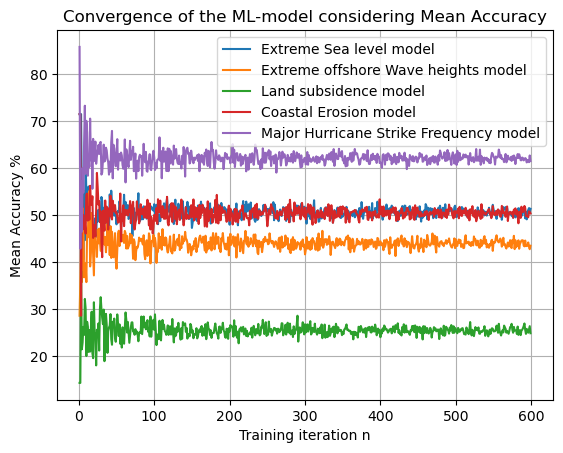

In [101]:
esl=[]
ewl=[]
ls=[]
se=[]
hurr=[]
for df in df_mach_learn_convergence_check:
    for row_num,row in df.iterrows():
        if row_num==0:
            esl.append(row["mean_acc"])
        elif row_num==1:
            ewl.append(row["mean_acc"])
        elif row_num==2:
            ls.append(row["mean_acc"])
        elif row_num==3:
            se.append(row["mean_acc"])
        elif row_num==4:
            hurr.append(row["mean_acc"])
       
# Generate x values
x_values = range(1, len(df_mach_learn_convergence_check) + 1)

# Plotting
plt.plot(x_values, np.mean([esl], axis=0), label='Extreme Sea level model')
plt.plot(x_values, np.mean([ewl], axis=0), label='Extreme offshore Wave heights model' )
plt.plot(x_values, np.mean([ls], axis=0), label='Land subsidence model')
plt.plot(x_values, np.mean([se], axis=0), label='Coastal Erosion model')
plt.plot(x_values, np.mean([hurr], axis=0), label='Major Hurricane Strike Frequency model')

# Add titles and labels
plt.title("Convergence of the ML-model considering Mean Accuracy")
plt.xlabel("Training iteration n")
plt.ylabel("Mean Accuracy %")
plt.legend()  # Add a legend to the plot
plt.grid(True)  # Add grid for better readability

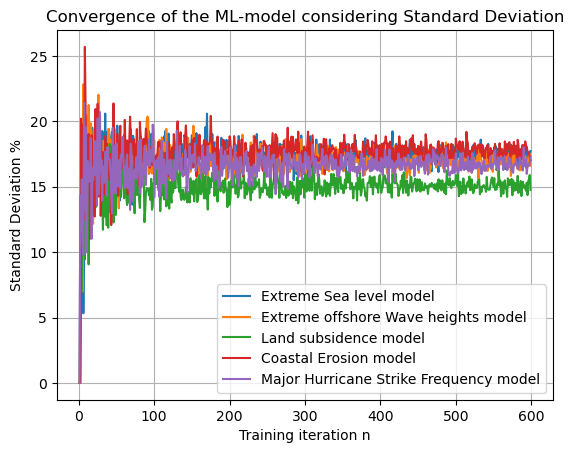

In [102]:
esl=[]
ewl=[]
ls=[]
se=[]
hurr=[]
for df in df_mach_learn_convergence_check:
    for row_num,row in df.iterrows():
        if row_num==0:
            esl.append(row["std_acc"])
        elif row_num==1:
            ewl.append(row["std_acc"])
        elif row_num==2:
            ls.append(row["std_acc"])
        elif row_num==3:
            se.append(row["std_acc"])
        elif row_num==4:
            hurr.append(row["std_acc"])
       
# Generate x values
x_values = range(1, len(df_mach_learn_convergence_check) + 1)

# Plotting
plt.plot(x_values, np.mean([esl], axis=0), label='Extreme Sea level model')
plt.plot(x_values, np.mean([ewl], axis=0), label='Extreme offshore Wave heights model')
plt.plot(x_values, np.mean([ls], axis=0), label='Land subsidence model')
plt.plot(x_values, np.mean([se], axis=0), label='Coastal Erosion model')
plt.plot(x_values, np.mean([hurr], axis=0), label='Major Hurricane Strike Frequency model')

# Add titles and labels
plt.title("Convergence of the ML-model considering Standard Deviation")
plt.xlabel("Training iteration n")
plt.ylabel("Standard Deviation %")
plt.legend()  # Add a legend to the plot
plt.grid(True)  # Add grid for better readability

In [54]:
# Load the model from the file
loaded_model = joblib.load(os.path.join(directory,model_name))

# Make predictions with the loaded model
y_pred = loaded_model.predict(X_test)
y_pred

array([4., 2., 3., 2., 3., 2., 3.])